<p style="font-family:Times New Roman; font-size:120%">
    -Aleksander Nistad Sekkelsten
</p>
<h1 style="font-family:Times New Roman; font-size: 300%"><center> Machine Learning For Physics; Exercise week 38 </center></h1>

I will now derive the decomposition of the Mean Squared Error (MSE) into the bias, variance, and irreducible error components. Specifically, we aim to prove the following:

$$
\mathbb{E}[(y - \hat{y})^2] = \text{Bias}(\hat{y})^2 + \text{Var}(\hat{y}) + \sigma^2
$$

where $y$ is the true value, $\hat{y}$ is the predicted value, and $\sigma^2$ is the variance of the irreducible noise.

To begin, recall the general definition of variance:
$$
\text{Var}(x) = \mathbb{E}[x^2] - (\mathbb{E}[x])^2
$$

Applying this to the MSE, we start by expanding the expression $\mathbb{E}[(y - \hat{y})^2]$ in terms of variance and expectation:

$$
\mathbb{E}[(y - \hat{y})^2] = \text{Var}(y - \hat{y}) + \left( \mathbb{E}[y - \hat{y}] \right)^2
$$

Next, we separate the variance terms for $y$ and $\hat{y}$, knowing that $y = f(x) + \epsilon$, where $\epsilon \sim N(0, \sigma^2)$:

$$
\text{Var}(y - \hat{y}) = \text{Var}(y) + \text{Var}(\hat{y})
$$

Given that $\text{Var}(y) = \sigma^2$, we can substitute this back into the expression:

$$
\mathbb{E}[(y - \hat{y})^2] = \sigma^2 + \text{Var}(\hat{y}) + \left( \mathbb{E}[y] - \mathbb{E}[\hat{y}] \right)^2
$$

Recognizing that $\left( \mathbb{E}[y] - \mathbb{E}[\hat{y}] \right)^2$ is the definition of the squared bias, $\text{Bias}(\hat{y})^2$, we arrive at the final form:

$$
\mathbb{E}[(y - \hat{y})^2] = \sigma^2 + \text{Var}(\hat{y}) + \text{Bias}(\hat{y})^2
$$

This shows that the MSE is composed of three terms: the irreducible error $\sigma^2$, the variance of the predictions $\text{Var}(\hat{y})$, and the squared bias $\text{Bias}(\hat{y})^2$.


In [2]:
import Pkg; Pkg.activate(".julia/environments/v1.10/Project.toml")
Pkg.add(["SCS", "Convex","PlotThemes","Images"])
using Plots, Random, NBInclude, LinearAlgebra, Statistics, Distributions, Convex, SCS, Images
using Plots.PlotMeasures
using StatsBase: sample
theme(:dao)

  Activating project at `~/.julia/environments/v1.10`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [9]:
#X and Y range
X = range(-1,3,500) |> collect 

Random.seed!(123)
ϵ=Normal(0, 0.1) # Noise
f(x) = ℯ^(-x^2) + 1.5 * ℯ^(-(x-2)^2)
Y = f.(X) .+ rand(ϵ,500)
Y_noNoise = f.(X)

500-element Vector{Float64}:
 0.36806455587757236
 0.37399504223597035
 0.3799724523691772
 0.3859960008418281
 0.392064872402101
 0.3981782219555494
 0.4043351745586737
 0.41053482543256686
 0.41677623999696467
 0.42305845392501085
 0.4293804732190404
 0.4357412743076658
 0.44213980416443854
 ⋮
 0.6533521049528822
 0.6438227689422453
 0.6343510941152579
 0.624938636401511
 0.615586906611578
 0.6062973703162605
 0.5970714477571039
 0.5879105137877693
 0.5788158978458241
 0.5697888839544931
 0.560830710753892
 0.5519425715612502

In [25]:
function Regression(xData, yData, numDegrees::Int64; λ=0)
    DesignMatrix = zeros(length(xData), numDegrees+1)
    for i in 1:numDegrees+1
        DesignMatrix[:,i].=xData.^(i-1)
    end
    Hessian = Transpose(DesignMatrix)*DesignMatrix
    beta = inv(Hessian+λ*I)*Transpose(DesignMatrix)*yData
    return beta
end

function RandomPolyDegModel(xData, betas)
    #This function will calculate ỹ = ∑ β_i x^i for any number of degrees 
    N = length(xData)
    DesignMatrix = zeros(length(xData), length(betas)) 
    for i in 1:length(betas)
        DesignMatrix[:,i].=xData.^(i-1)
    end
    est = DesignMatrix*betas
    return est
end

function SplitData(xData::Array, yData::Array, train_size::Float64)
    #Assumes Data : n_features, n_observations
    
    if ndims(xData)==1
        N = length(xData)
        NumTrain = Int(round(N*train_size))
            
        train_indices = sample(1:N, NumTrain; replace=false)
        all_indices = collect(1:N)
        test_indices = [i for i in all_indices if i ∉ train_indices]
        
        xTrain = xData[train_indices]
        yTrain = yData[train_indices]
        xTest = xData[test_indices]
        yTest = yData[test_indices]
        
    elseif ndims(xData)==2 #If there are for multiple features for each datapoint i.e position, velocity
        N = length(xData[1,:])
        NumTrain = Int(round(N*train_size))
            
        train_indices = sample(1:N, NumTrain; replace=false)
        all_indices = collect(1:N)
        test_indices = [i for i in all_indices if i ∉ train_indices]
        
        xTrain = xData[:,train_indices]
        yTrain = yData[:,train_indices]
        xTest = xData[:,test_indices]
        yTest = yData[:,test_indices]
    else #This is undefined
        @warn "Array dimensions do not match the expected dimensions." 
        println("Expected: 1 or 2, but got: ", ndims(xData))
        return
    end
    return xTrain, xTest, yTrain, yTest
end

SplitData (generic function with 1 method)

In [15]:
xtrain, xtest, ytrain, ytest = SplitData(X, Y, 0.8)

([1.933867735470942, -0.5831663326653307, 1.3567134268537073, 2.246492985971944, -0.0781563126252505, 2.438877755511022, 0.531062124248497, 1.7254509018036073, 2.6953907815631264, 1.845691382765531  …  2.7034068136272547, 1.5731462925851702, 1.276553106212425, -0.11823647294589178, -0.9038076152304609, 1.4448897795591182, 1.2364729458917836, 2.0220440881763526, 0.35470941883767537, 2.8076152304609217], [-0.9839679358717435, -0.9679358717434869, -0.9278557114228457, -0.8797595190380761, -0.8476953907815631, -0.8316633266533067, -0.8156312625250501, -0.7995991983967936, -0.7915831663326653, -0.7595190380761523  …  2.5110220440881763, 2.5190380761523046, 2.5511022044088176, 2.6713426853707416, 2.7515030060120242, 2.783567134268537, 2.81563126252505, 2.847695390781563, 2.8717434869739478, 2.935871743486974], [1.4109203606273104, 0.6180085603476981, 1.1542603859263163, 1.605735928973744, 0.9697008626492247, 1.1581114985325904, 0.7803625380303714, 1.3523810223806938, 0.8792670766452823, 1.46

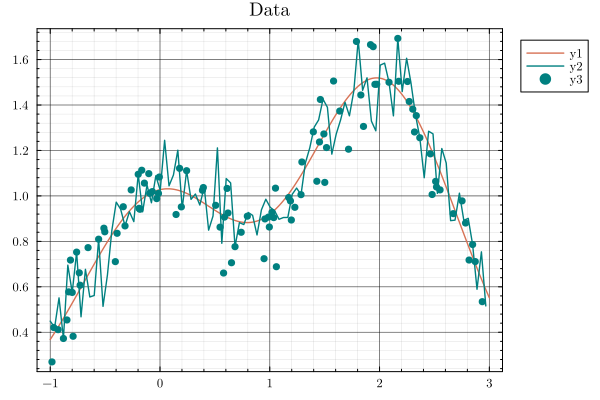

In [24]:
plot(X,Y_noNoise,title="Data")
plot!(X[1:5:end],Y[1:5:end],c=:teal)
scatter!(xtest,ytest,title="Data",c=:teal)

In [99]:
function Bootstrap(xData, yData, numDegrees::Int64, numBootstraps::Int64; λ=0)
    N = length(xData)
    betas = zeros(numDegrees+1,numBootstraps)
    
    for b in 1:numBootstraps
        # Sample indices with replacement to create a bootstrap sample
        bootstrap_indices = sample(1:N, N; replace=true)
        
        # Create bootstrap sample for xTrain, yTrain, and zTrain
        xBootstrap = xData[bootstrap_indices]
        yBootstrap = yData[bootstrap_indices]

        # Perform regression on the bootstrap sample
        betaVals = Regression(xBootstrap, yBootstrap, numDegrees, λ=0)
        # Store the regression coefficients
        betas[:,b] .= betaVals
    end

    return betas
end

Bootstrap (generic function with 1 method)

In [125]:

n=86
X = range(-3,3,n) |> collect 

Random.seed!(123)
ϵ=Normal(0, 0.1) # Noise
f(x) = ℯ^(-x^2) + 1.5 * ℯ^(-(x-2)^2)
Y = f.(X) .+ rand(ϵ,n)
xtrain, xtest, ytrain, ytest = SplitData(X, Y, 0.8)

degs = range(0,14) |> collect
numBootstraps=100
errors = zeros(length(degs))
biases = zeros(length(degs))
variances = zeros(length(degs))
            
est_test = zeros(length(xtest),numBootstraps)       
for (i,deg) in enumerate(degs)
    
    #  ----  Apply Bootstrap  ----
    bootstrapBetas = Bootstrap(xtrain,ytrain, deg, numBootstraps)

    #  ----  Analyzing Results  ----
    for i in 1:numBootstraps
        est_test[:,i] = RandomPolyDegModel(xtest, bootstrapBetas[:,i])
    end
    
    #  ----  Update: Error, Bias and Variance  ----
    error_temp = zeros(length(ytest))
        
    for i in 1:length(ytest)
        error_temp[i] = mean( (ytest[i] .- est_test[i,:]).^2 )
        
    end
    #display(error_temp)
    errors[i] = mean( error_temp )
    biases[i] = mean( (ytest .- mean(est_test, dims=2)).^2 )
    variances[i] = mean( var(est_test, dims=2) )
end

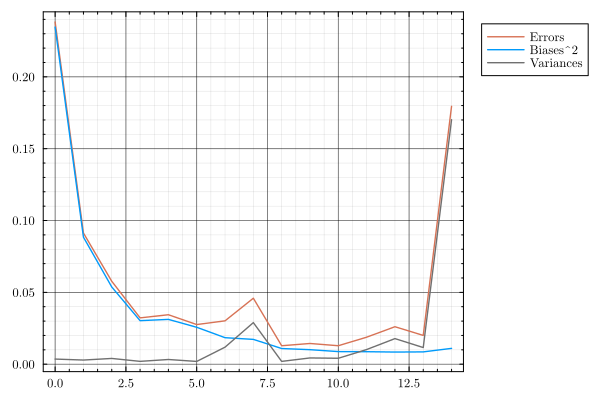

In [126]:
plot(degs, (errors), label="Errors")
plot!(degs, (biases), label="Biases^2")
plot!(degs, (variances), label="Variances")